# Pruning

In [1]:
import sys
sys.path.append("..")

In [92]:
from asyncio import MultiLoopChildWatcher
from doctest import OutputChecker

from turtle import hideturtle
import warnings

from models import GeneralModel
from models.statistics.Metrics import Metrics
from utils.config_utils import *
from utils.model_utils import *
from utils.system_utils import *

import matplotlib.pyplot as plt
from models.networks.ConvertMLP import ConvertMLP2,ConvertMLP3

from verify_utils.verify_utils import verify_single_image

warnings.filterwarnings("ignore")

In [3]:
torch.__version__

'1.11.0+cu113'

In [4]:
# define arguments manually
arguments = argparse.Namespace()
# device
arguments.device = "cuda"

# define arguments for model
#arguments.model = "ResNet18" # ResNet not supported for structured
arguments.model = "MLP2"
arguments.hidden_dim = 64
#arguments.input_dim = None # for ResNet
#arguments.input_dim = (1,1,1) # for LeNet5
arguments.input_dim = (28,28) # for MNIST
arguments.output_dim = 10
arguments.disable_masking = 1 # 0 for disable mask, 1 for mask (unstructured)
arguments.track_weights = 0
arguments.enable_rewinding = 0
arguments.growing_rate = 0.0000
arguments.outer_layer_pruning = 0
# arguments.prune_criterion = "SNIPit"  # unstructured

arguments.prune_criterion = "SNAPit" # or SNAPit ... # structured
arguments.l0 = 0
arguments.l0_reg = 1.0
arguments.l1_reg = 0
arguments.lp_reg = 0
arguments.l2_reg = 5e-5
arguments.hoyer_reg = 0.001
arguments.N = 6000 # different for different dataset
arguments.beta_ema = 0.999


# define arguments for criterion
arguments.pruning_limit = 0.5
arguments.snip_steps = 6

# not pre-trained model
arguments.checkpoint_name = None
arguments.checkpoint_model = None

# dataset
arguments.data_set = "MNIST"
arguments.batch_size = 512
arguments.mean = (0.1307,)
arguments.std = (0.3081,)
arguments.tuning = 0
arguments.preload_all_data = 0
arguments.random_shuffle_labels = 0

# loss
arguments.loss = "CrossEntropy"

# optimizer
arguments.optimizer = "ADAM"
arguments.learning_rate = 2e-3

# training
arguments.save_freq = 1e6
arguments.eval = 0
arguments.train_scheme = "DefaultTrainer"
arguments.seed = 1234
arguments.epochs = 5

arguments.grad_noise = 0
arguments.grad_clip =10
arguments.eval_freq = 1000
arguments.max_training_minutes= 6120
arguments.plot_weights_freq = 50
arguments.prune_delay = 0
arguments.prune_freq = 1
arguments.rewind_to = 6

arguments.skip_first_plot = 0
arguments.disable_histograms = 0
arguments.disable_saliency = 0
arguments.disable_confusion = 0
arguments.disable_weightplot = 0
arguments.disable_netplot = 0
arguments.disable_activations = 0

arguments.pruning_rate = 0
# during training
arguments.pruning_freq = 1

In [5]:
metrics = Metrics()
out = metrics.log_line
print = out

ensure_current_directory()
global out 
out = metrics.log_line
out(f"starting at {get_date_stamp()}")

metrics._batch_size = arguments.batch_size
metrics._eval_freq = arguments.eval_freq

starting at 2022-04-21_16.47.10


In [6]:
device = configure_device(arguments)

In [7]:
# get model
model: GeneralModel = find_right_model(
        NETWORKS_DIR,arguments.model,
        device=device,
        hidden_dim = arguments.hidden_dim,
        input_dim = arguments.input_dim,
        output_dim = arguments.output_dim,
        is_maskable=arguments.disable_masking,
        is_tracking_weights=arguments.track_weights,
        is_rewindable=arguments.enable_rewinding,
        is_growable=arguments.growing_rate > 0,
        outer_layer_pruning=arguments.outer_layer_pruning,
        maintain_outer_mask_anyway=(
                                       not arguments.outer_layer_pruning) and (
                                           "Structured" in arguments.prune_criterion),
        l0=arguments.l0,
        l0_reg=arguments.l0_reg,
        N=arguments.N,
        beta_ema=arguments.beta_ema,
        l2_reg=arguments.l2_reg
    ).to(device)

In [8]:
for key,param in model.named_parameters():
    print(param.size())

torch.Size([64, 784])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [9]:
# get criterion
criterion = find_right_model(
        CRITERION_DIR,arguments.prune_criterion,
        model=model,
        limit=arguments.pruning_limit,
        start=0.5,
        steps=arguments.snip_steps,
        device=arguments.device
    )   

In [10]:
def load_checkpoint(arguments, metrics, model):
    if (not (arguments.checkpoint_name is None)) and (not (arguments.checkpoint_model is None)):
        path = os.path.join(RESULTS_DIR, arguments.checkpoint_name, MODELS_DIR, arguments.checkpoint_model)
        state = DATA_MANAGER.load_python_obj(path)
        try:
            model.load_state_dict(state)
        except KeyError as e:
            print(list(state.keys()))
            raise e
        out(f"Loaded checkpoint {arguments.checkpoint_name} from {arguments.checkpoint_model}")

# load pre-trained weights if specified
load_checkpoint(arguments, metrics, model)  

In [11]:
# load data
train_loader, test_loader = find_right_model(
        DATASETS, arguments.data_set,
        arguments=arguments,
        mean=arguments.mean,
        std=arguments.std
    )

Using mean (0.1307,)


In [12]:
# get loss function
loss = find_right_model(
        LOSS_DIR, arguments.loss,
        device=device,
        l1_reg=arguments.l1_reg,
        lp_reg=arguments.lp_reg,
        l0_reg=arguments.l0_reg,
        hoyer_reg=arguments.hoyer_reg
    )

In [13]:
# get optimizer
optimizer = find_right_model(
        OPTIMS, arguments.optimizer,
        params=model.parameters(),
        lr=arguments.learning_rate,
        weight_decay=arguments.l2_reg if not arguments.l0 else 0
    )


In [14]:
if not arguments.eval:
    # build trainer
    run_name = f'_model={arguments.model}_dataset={arguments.data_set}_prune-criterion={arguments.prune_criterion}' + \
               f'_pruning-limit={arguments.pruning_limit}_train-scheme={arguments.train_scheme}_seed={arguments.seed}'
    trainer = find_right_model(
            TRAINERS_DIR, arguments.train_scheme,
            model=model,
            loss=loss,
            optimizer=optimizer,
            device=device,
            arguments=arguments,
            train_loader=train_loader,
            test_loader=test_loader,
            metrics=metrics,
            criterion=criterion,
            run_name = run_name
        )

Made datestamp: 2022-04-21_16.47.14_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234


In [15]:
trainer.train()

Started training
Saved results/2022-04-21_16.47.14_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234/output/scores
pruning 25088 percentage 0.5 length_nonzero 50176
pruning 320 percentage 0.5 length_nonzero 640
  (layers): Sequential(
    (0): ContainerLinear(in_features=784, out_features=32.0, bias=True)
    (2): ContainerLinear(in_features=32.0, out_features=10, bias=True)
final percentage after snap: 0.5
Saved results/2022-04-21_16.47.14_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234/output/scores
pruning 784 percentage 0.03125 length_nonzero 25088
pruning 10 percentage 0.03125 length_nonzero 320
  (layers): Sequential(
    (0): ContainerLinear(in_features=784, out_features=31.0, bias=True)
    (2): ContainerLinear(in_features=31.0, out_features=10, bias=True)
final percentage after snap: 0.03125
Saved results/2022-04-21_16.47.14_model=MLP2_dataset=MNIST_prune-criterion=SNA

<Figure size 432x288 with 0 Axes>

In [16]:
for key,param in model.named_parameters():
    print(param.size())

torch.Size([31, 784])
torch.Size([31])
torch.Size([10, 31])
torch.Size([10])


# Pruning

In [51]:
# change to cpu and eval mode
model.to("cpu").eval()

# get the model parameters
state = model.state_dict()
# convet the model to a quantizable model
q_model= ConvertMLP2(model)
# load previous parameter
q_model.load_state_dict(state)
# set quantization config
q_model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
# fuse_model
q_model.fuse

<bound method ConvertMLP2.fuse of ConvertMLP2(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=31, bias=True)
    (1): ReLU()
    (2): Linear(in_features=31, out_features=10, bias=True)
  )
  (quant): QuantStub()
  (dequant): DeQuantStub()
)>

In [52]:
# use calibrate date to calibrate model
model_prepared = torch.quantization.prepare(q_model)
cali_data,label=next(iter(train_loader))
model_prepared(cali_data)

tensor([[  0.5847,  -5.2044,  -2.3644,  ..., -11.3830,   1.3380,  -4.3807],
        [  2.5568,  -5.2369,   4.1925,  ...,  -2.5161,   1.5116,  -1.6804],
        [ -1.7397,  -7.6789,  -2.3339,  ..., -10.4554,   2.9656,  -6.0093],
        ...,
        [ -1.2047, -10.4999,  -7.7756,  ...,  -2.0436,   0.8609,   5.6215],
        [ -5.9612,  -5.1753,  -0.5726,  ...,  12.3875,  -0.4170,   2.5765],
        [  0.3165,  -7.2766,  -4.6405,  ...,  -5.9404,  -4.0411,  -1.6828]],
       grad_fn=<AddmmBackward0>)

In [53]:
# convert to int8
model_int8 = torch.quantization.convert(model_prepared)

In [54]:
model_int8(cali_data)

tensor([[  0.5895,  -5.0109,  -2.3581,  ..., -11.2009,   1.1790,  -4.4214],
        [  2.3581,  -5.3057,   4.1266,  ...,  -2.6528,   1.4738,  -1.4738],
        [ -1.7686,  -7.6638,  -2.3581,  ..., -10.3166,   3.2424,  -5.8952],
        ...,
        [ -1.1790, -10.3166,  -7.3690,  ...,  -2.3581,   1.1790,   5.6005],
        [ -5.6005,  -5.0109,  -0.2948,  ...,  12.3799,  -0.2948,   2.3581],
        [  0.2948,  -7.0743,  -4.7162,  ...,  -6.1900,  -4.1266,  -1.4738]])

In [55]:
model_int8

ConvertMLP2(
  (layers): Sequential(
    (0): QuantizedLinear(in_features=784, out_features=31, scale=0.4623158276081085, zero_point=78, qscheme=torch.per_channel_affine)
    (1): ReLU()
    (2): QuantizedLinear(in_features=31, out_features=10, scale=0.29476067423820496, zero_point=68, qscheme=torch.per_channel_affine)
  )
  (quant): Quantize(scale=tensor([0.0254]), zero_point=tensor([16]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

In [81]:
# compare the model size
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

In [83]:
size_model_fp32 = print_size_of_model(model,label="fp32model")
size_model_int8 = print_size_of_model(model_int8,label="quantized")


model:  fp32model  	 Size (KB): 100.127
model:  quantized  	 Size (KB): 29.691


In [ ]:
# how to verify a quantized model

# Verify

In [100]:
img,label=next(iter(test_loader))
img_test = img[0].squeeze().to(device)
model.to(device)
img,label=verify_single_image(model,img_test,0.1)

  0%|          | 0/9 [00:00<?, ?it/s]

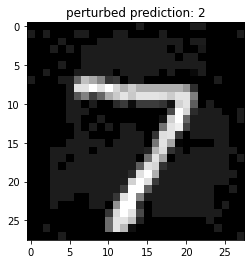

In [99]:
plt.imshow(img.value.reshape(28, 28), cmap='gray')
plt.title(f"perturbed prediction: {label.value.argmax()}")
plt.show()